## Introduction ##

A used car sales service is developing an app to attract new customers where users can quickly find out the market value of their car. In this project, we will need to build the model that predicts the car values. The company is interested in the quality and speed of the prediction, and the time required for model training. We have access to historical data such as technical specifications, trim versions, and prices, which are further detailed in the file **car_data.csv**.

Using the dataset, we will train, tune, and evaluate different models using the RMSE metric; our goal is to develop a time-efficient, high-quality model.

## Data Preparation ##

**Initialization**

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

**Load and Inspect Data**

In [2]:
# When cloning this project, ensure directory/file paths are correct with respect to user's operating system
df_cars = pd.read_csv('datasets/car_data.csv')

display(df_cars.sample(10))
df_cars.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
208455,05/04/2016 09:52,1,small,1999,manual,0,polo,150000,8,petrol,volkswagen,yes,05/04/2016 00:00,0,13589,05/04/2016 10:40
148882,25/03/2016 11:43,749,wagon,1992,manual,115,passat,150000,4,petrol,volkswagen,no,25/03/2016 00:00,0,51597,31/03/2016 18:16
107709,24/03/2016 10:48,6500,NaN,2017,manual,105,a3,150000,0,gasoline,audi,no,24/03/2016 00:00,0,53937,24/03/2016 10:48
93698,25/03/2016 09:55,1600,small,2002,manual,50,lupo,150000,3,petrol,volkswagen,no,25/03/2016 00:00,0,12355,31/03/2016 16:45
344152,12/03/2016 19:06,5900,bus,2006,manual,105,touran,150000,1,gasoline,volkswagen,no,12/03/2016 00:00,0,35649,17/03/2016 21:17
194679,17/03/2016 07:58,3290,sedan,2004,manual,116,a_klasse,125000,9,petrol,mercedes_benz,yes,17/03/2016 00:00,0,37318,21/03/2016 11:45
308796,18/03/2016 01:36,650,sedan,1996,manual,0,a4,150000,0,petrol,audi,NaN,18/03/2016 00:00,0,41199,21/03/2016 06:46
289851,26/03/2016 20:36,2950,sedan,2003,NaN,0,golf,150000,11,gasoline,volkswagen,no,26/03/2016 00:00,0,51491,26/03/2016 21:47
351935,14/03/2016 09:32,9900,wagon,2007,manual,280,vectra,150000,11,petrol,opel,no,14/03/2016 00:00,0,35753,06/04/2016 18:48
46653,21/03/2016 11:49,3699,small,2011,NaN,71,fortwo,125000,1,petrol,smart,no,21/03/2016 00:00,0,70193,21/03/2016 11:49


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

There are 354,369 observations in the dataset. For columns with timestamps, we'll convert the datatype to datetime. The object datatypes will be converted to category to facilitate the feature encoding when we train the LightGBM regressor model.

In [3]:
df_cars['DateCrawled'] = pd.to_datetime(df_cars['DateCrawled'], format='%d/%m/%Y %H:%M')
df_cars['DateCreated'] = pd.to_datetime(df_cars['DateCreated'], format='%d/%m/%Y %H:%M')
df_cars['LastSeen'] = pd.to_datetime(df_cars['LastSeen'], format='%d/%m/%Y %H:%M')

print(df_cars.dtypes)

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Mileage                       int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object


**Missing Values**

In [4]:
print(df_cars.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


There are missing values, primiarly in categorical columns. While these represent more than 20% of the dataset, it is difficult to accurately recreate the values. Specifically, it would be difficult to recreate the NotRepaired feature, which arguably is an important feature affecting the value of a vehicle. As such, we'll drop the missing values.

In [5]:
df_cars = df_cars.dropna(subset=['NotRepaired', 'Model', 'VehicleType', 'Gearbox', 'FuelType']).reset_index()
print(df_cars.isna().sum())

index                0
DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


**Duplicate Observations**

We'll check for duplicate entries and remove any duplicate rows found in the dataset.

In [6]:
print('Number of duplicates: ', df_cars.duplicated().sum())

Number of duplicates:  0


**Negative Prices**

We'll check to make sure the target values make sense (i.e. no negative car values).

In [7]:
print('Number of negative prices: ', (df_cars['Price'] < 0).sum())

Number of negative prices:  0


**Categorical Feature Datatype**

As previously mentioned, we'll convert object datatypes to category to facilitate the LightGBM encoding.

In [8]:
obj_feat = list(df_cars.loc[:, df_cars.dtypes == 'object'].columns.values)
for feat in obj_feat:
    df_cars[feat] = pd.Series(df_cars[feat], dtype="category")

df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245814 entries, 0 to 245813
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   index              245814 non-null  int64         
 1   DateCrawled        245814 non-null  datetime64[ns]
 2   Price              245814 non-null  int64         
 3   VehicleType        245814 non-null  category      
 4   RegistrationYear   245814 non-null  int64         
 5   Gearbox            245814 non-null  category      
 6   Power              245814 non-null  int64         
 7   Model              245814 non-null  category      
 8   Mileage            245814 non-null  int64         
 9   RegistrationMonth  245814 non-null  int64         
 10  FuelType           245814 non-null  category      
 11  Brand              245814 non-null  category      
 12  NotRepaired        245814 non-null  category      
 13  DateCreated        245814 non-null  datetime

## Exploratory Data Analysis

While we won't be using all of the numerical features to train our models, we'll conduct EDA on the numerical features and target variable we plan on using; namely power, mileage, registration year and price.

In [9]:
display(df_cars[['Power', 'Mileage', 'RegistrationYear', 'Price']].describe())

,Power,Mileage,RegistrationYear,Price
count,245814.000000,245814.000000,245814.000000,245814.000000
mean,119.970884,127296.716216,2002.918699,5125.346717
std,139.387116,37078.820368,6.163765,4717.948673
min,0.000000,5000.000000,1910.000000,0.000000
25%,75.000000,125000.000000,1999.000000,1499.000000
50%,110.000000,150000.000000,2003.000000,3500.000000
75%,150.000000,150000.000000,2007.000000,7500.000000
max,20000.000000,150000.000000,2018.000000,20000.000000


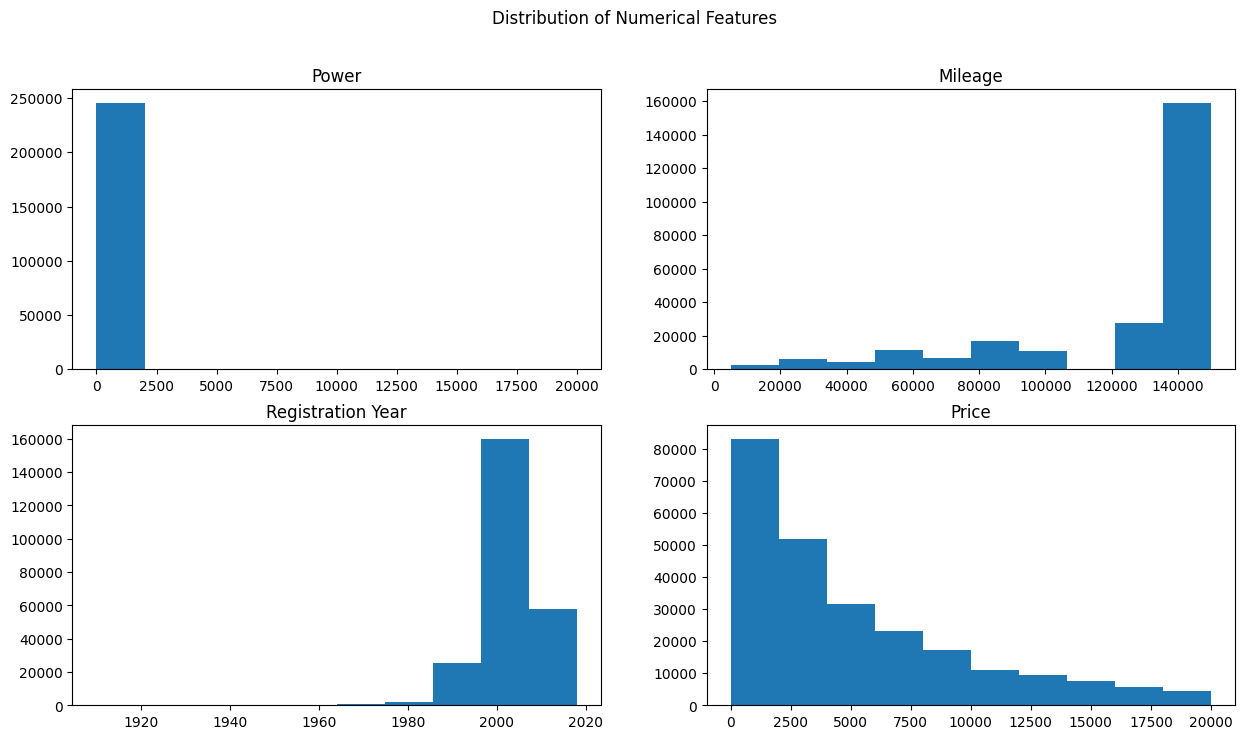

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8)) 

axs[0, 0].hist(df_cars['Power'])
axs[0, 0].set_title('Power')

axs[0, 1].hist(df_cars['Mileage'])
axs[0, 1].set_title('Mileage')

axs[1, 0].hist(df_cars['RegistrationYear'])
axs[1, 0].set_title('Registration Year')

axs[1, 1].hist(df_cars['Price'])
axs[1, 1].set_title('Price')

fig.suptitle('Distribution of Numerical Features')
plt.show()

It appears there are errors in the Power column; some of the values are 0 and some of the values are extraordinarily high. This could be a sample of mixed units other than horsepower (e.g. Joules/second), but most likely is erroneous. In any case, we shouldn't use Power as a training feature.

## Model Training and Tuning ##

We'll train and compare a few regression models, using RMSE, time to train, and prediction time as our evaluation metrics. For a sanity check, we'll train a linear regression model with default parameters. The models we'll train and tune for comparison will be as follows:

- Random Forest Regressor
- LightGBM Regressor
- CatBoost Regressor

For hyperparameter tuning, we'll incorporate the use of GridSearchCV with a narrow scope of parameters to mitigate long runtimes. GridSearchCV incorporates cross-validation and includes attributes related to our performance metrics, specifically refit_time_ which measures time to train for the best estimator across the entire provided dataset (i.e. training set).

To facilitate the performance comparison for our baseline models and predictions, we'll define the following functions:

**time_and_train:**  
*Parameters:*
- model: estimator to be trained
- feat_train: array-like of features for model training
- tgt_train: array-like of targets for model training

*Returns:* tuple of fitted model and time to train in seconds, rounded to the nearest hundredth. Primarily used for our baseline performance calculations.

In [11]:
def time_and_train(model, feat_train, tgt_train):
    start = time.perf_counter()
    fitted_model = model.fit(feat_train, tgt_train)
    elapsed_time = round(time.perf_counter() - start, 2)

    return fitted_model, elapsed_time

**evaluate_predict:**  
*Parameters:*
- model: trained model to be used for evaluation
- feat_val: array-like of features for model prediction
- tgt_val: array-like of true target values

*Returns:* tuple of RMSE and prediction time in seconds, rounded to the nearest hundredth.

In [12]:
def evaluate_predict(model, feat_val, tgt_val):
    start = time.perf_counter()
    rmse = mean_squared_error(tgt_val, model.predict(feat_val), squared=False)
    elapsed_time = round(time.perf_counter() - start, 2)

    return rmse, elapsed_time

**Splitting the Dataset**

Since we're interested in features directly related to car values, fields that do not necessarily influence price (such as pictures on the website and creation date) will not be included in the training/validation sets. As there are a number of categorical columns, we'll encode these features (using OHE) for the linear regression and random forest regressor models. The split datasets prior to dummy creation will be retained for use with the other regression models. The split will use a 3:1 ratio.

In [13]:
X = df_cars.drop(['index', 'DateCrawled', 'Price', 'Power', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
y = df_cars['Price']
X_ohe = pd.get_dummies(X, drop_first=True)

X_train, X_valid, y_train, y_valid = train_test_split(X_ohe, y, test_size=.25, random_state=12345)

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(184360, 303)
(184360,)
(61454, 303)
(61454,)


**Linear Regression**

As previously mentioned, we'll train and evaluate a linear regression model using the default parameters to serve as a sanity check for our comparisons.

In [14]:
lr_model, lr_time_train = time_and_train(LinearRegression(n_jobs=-1), X_train, y_train)
lr_rmse, lr_time_predict = evaluate_predict(lr_model, X_valid, y_valid)

print('Linear Regression Model RMSE: ', lr_rmse)
print('Time to train: ', lr_time_train)
print('Prediction time: ', lr_time_predict)

Linear Regression Model RMSE:  2717.9467013491317
Time to train:  3.83
Prediction time:  0.08


**Random Forest Regressor**

We'll evaluate a forest regressor model with its default parameters to get a performance baseline prior to tuning the model's hyperparameters.

In [15]:
base_rf_model, base_rf_time_train = time_and_train(RandomForestRegressor(random_state=12345, n_jobs=-1), X_train, y_train)
base_rf_rmse, base_rf_time_predict = evaluate_predict(base_rf_model, X_valid, y_valid)

print('Baseline Random Forest Regression Model RMSE: ', base_rf_rmse)
print('Time to train: ', base_rf_time_train)
print('Prediction time: ', base_rf_time_predict)

Baseline Random Forest Regression Model RMSE:  1853.9002187562412
Time to train:  100.01
Prediction time:  0.65


**Random Forest Regressor Grid Search**

The hyperparameters we'll tune for the random forest model will be maximum tree depth, maximum features, and number of estimators.

In [17]:
parameters = {'n_estimators': [10, 50, 100],
                'max_features': [None, 'log2', 'sqrt'],
                'max_depth': [25, 50, 75]}

rf_results = GridSearchCV(RandomForestRegressor(random_state=12345), param_grid=parameters, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_results.fit(X_train, y_train)

final_rf_rmse, final_rf_time_predict = evaluate_predict(rf_results.best_estimator_, X_valid, y_valid)
final_rf_time_train = rf_results.refit_time_

print('Final Random Forest Regression Model RMSE: ', final_rf_rmse)
print('Time to train: ', final_rf_time_train)
print('Prediction time: ', final_rf_time_predict)
print('Best parameters: ', rf_results.best_params_)

Final Random Forest Regression Model RMSE:  1823.579556798576
Time to train:  66.23051571846008
Prediction time:  1.77
Best parameters:  {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}


**LightGBM**

Like the previous iterations, we'll print the baseline performance metrics below using the model's default parameters.

In [18]:
# Resplit data to remove OHE
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=12345)

In [19]:
lgbm_model, base_lgbm_time_train = time_and_train(LGBMRegressor(random_state=12345, n_jobs=-1), X_train, y_train)
base_lgbm_rmse, base_lgbm_time_predict = evaluate_predict(lgbm_model, X_valid, y_valid)

print('Baseline LightGBM Regressor RMSE: ', base_lgbm_rmse)
print('Time to train: ', base_lgbm_time_train)
print('Prediction time: ', base_lgbm_time_predict)

Baseline LightGBM Regressor RMSE:  1837.9297659451765
Time to train:  0.56
Prediction time:  0.09


**LightGBM Regressor Grid Search**

The hyperparameters we'll tune for the model will be the number of leaves and learning rate.

In [20]:
parameters = {'learning_rate': np.array(list(range(5, 100, 5)))/100,
            'num_leaves': list(range(50, 301, 25))}

lgbm_grid = GridSearchCV(LGBMRegressor(random_state=12345), param_grid=parameters, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_grid.fit(X_train, y_train)

final_lgbm_rmse, final_lgbm_time_predict = evaluate_predict(lgbm_grid.best_estimator_, X_valid, y_valid)
final_lgbm_time_train = lgbm_grid.refit_time_

print('Final LightGBM Regressor Model RMSE: ', final_lgbm_rmse)
print('Time to train: ', final_lgbm_time_train)
print('Prediction time: ', final_lgbm_time_predict)
print('Best parameters: ', lgbm_grid.best_params_)

Final LightGBM Regressor Model RMSE:  1774.992020421616
Time to train:  1.716059923171997
Prediction time:  0.2
Best parameters:  {'learning_rate': 0.1, 'num_leaves': 275}


**CatBoost**

To handle categorical feature encoding for CatBoost, we'll need to specify the feature names (since they are datatype category vice object) and pass them to the cat_features parameter. The baseline metrics are printed below using the default parameters.

In [21]:
cat_features_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cbr_model, base_cbr_time_train = time_and_train(CatBoostRegressor(random_state=12345, cat_features=cat_features_list, verbose=False), X_train, y_train)
base_cbr_rmse, base_cbr_time_predict = evaluate_predict(cbr_model, X_valid, y_valid)

print('Baseline CatBoost Regressor RMSE: ', base_cbr_rmse)
print('Time to train: ', base_cbr_time_train)
print('Prediction time: ', base_cbr_time_predict)

Baseline CatBoost Regressor RMSE:  1861.3232492610937
Time to train:  56.38
Prediction time:  0.09


**CatBoost Regressor Grid Search**

The hyperparmeters we'll tune for the model will be tree depth and number of iterations.

In [22]:
parameters = {'depth' : [6, 8, 10],
              'iterations' : [500, 1000, 1500]}

cbr_grid = GridSearchCV(CatBoostRegressor(random_state=12345, cat_features=cat_features_list, verbose=False), param_grid=parameters, scoring='neg_root_mean_squared_error', n_jobs=-1)
cbr_grid.fit(X_train, y_train)

final_cbr_rmse, final_cbr_time_predict = evaluate_predict(cbr_grid.best_estimator_, X_valid, y_valid)
final_cbr_time_train = cbr_grid.refit_time_

print('Final CatBoost Regressor Model RMSE: ', final_cbr_rmse)
print('Time to train: ', final_cbr_time_train)
print('Prediction time: ', final_cbr_time_predict)
print('Best parameters: ', cbr_grid.best_params_)

Final CatBoost Regressor Model RMSE:  1790.6317812136517
Time to train:  189.81968641281128
Prediction time:  0.4
Best parameters:  {'depth': 10, 'iterations': 1500}


## Model Analysis ##

Displayed below is the combined results of our baseline evaluations and final evaluations for our models.

In [23]:
baseline_results = pd.DataFrame({'Random Forest Regressor': [base_rf_rmse, base_rf_time_train, base_rf_time_predict],
                                'LightGBM Regressor': [base_lgbm_rmse, base_lgbm_time_train, base_lgbm_time_predict],
                                'CatBoost Regressor': [base_cbr_rmse, base_cbr_time_train, base_cbr_time_predict]},
                                index=['RMSE', 'Time to Train', 'Prediction Time'])

final_results = pd.DataFrame({'Random Forest Regressor': [final_rf_rmse, final_rf_time_train, final_rf_time_predict],
                            'LightGBM Regressor': [final_lgbm_rmse, final_lgbm_time_train, final_lgbm_time_predict],
                            'CatBoost Regressor': [final_cbr_rmse, final_cbr_time_train, final_cbr_time_predict]},
                            index=['RMSE', 'Time to Train', 'Prediction Time'])

rf_diff = 100*(final_results['Random Forest Regressor'] - baseline_results['Random Forest Regressor'])/baseline_results['Random Forest Regressor']
lgbm_diff = 100*(final_results['LightGBM Regressor'] - baseline_results['LightGBM Regressor'])/baseline_results['LightGBM Regressor']
cbr_diff = 100*(final_results['CatBoost Regressor'] - baseline_results['CatBoost Regressor'])/baseline_results['CatBoost Regressor']

percent_change = pd.DataFrame({'% Change Random Forest': rf_diff, '% Change LightGBM': lgbm_diff, '% Change CatBoost': cbr_diff})

display(baseline_results)
display(final_results)
display(percent_change)

,Random Forest Regressor,LightGBM Regressor,CatBoost Regressor
RMSE,1853.900219,1837.929766,1861.323249
Time to Train,100.010000,0.560000,56.380000
Prediction Time,0.650000,0.090000,0.090000


,Random Forest Regressor,LightGBM Regressor,CatBoost Regressor
RMSE,1823.579557,1774.99202,1790.631781
Time to Train,66.230516,1.71606,189.819686
Prediction Time,1.770000,0.20000,0.400000


,% Change Random Forest,% Change LightGBM,% Change CatBoost
RMSE,-1.635507,-3.424383,-3.797915
Time to Train,-33.776107,206.439272,236.679117
Prediction Time,172.307692,122.222222,344.444444


After tuning hyperparameters for each model, the LightGBM regressor had the lowest overall RMSE. Additionally, this model had the best performance times; 1.72 seconds for time to train and a prediction time of 0.2 seconds for its final model evaluation. Both gradient boosting models and an increased time to train from their baselines, whereas the random forest regressor actually improved its time to train.

## Conclusion ##

In this project we explored the benefits of using gradient boosting models for target prediction, especially when there is an emphasis on performance metrics such as runtime. While the evaluation metric (RMSE) of each regression model were similar and within reasonable tolerances in terms of this project's scope (i.e. predicting car price in euros), we cannot overlook the advantages introduced by gradient boosting in terms of overall efficiency. Based on the results above, the app should incorporate the use of a LightGBM regressor model as it meets the criteria for model prediction quality and runtime performance.

Aside from the advantages gradient boosting models had in both time to train and prediction time, one aspect not directly explored in this project was optimization time. In each case, we incorporated a GridSearchCV for hyperparameter tuning, which can dramatically degrade optimization time as we add more search parameters. The search parameters selected in this project were not thoroughly exhaustive as a compromise between quality and time, but it is important to note that LightGBM and CatBoost support the integration of GPUs. This can drastically improve runtime as well as model quality as this offers opportunities for more expansive parameter tuning from a powerful dedicated source.

In terms of overall model prediction quality, improvements could be made with a more detailed exploration of feature selection and/or importance. As most of the features used for training were categorical, we can intuit the difficulty for a model to interpret features such as car trim for a particular make and model, or the impact of car repair to its value.